### Spatially-Resolved Grism Fitting

In which we use all the previous work on SED fitting to generate prior templates, and use this to fit 2D grism data.

<div class="alert alert-warning">

**Warning:**

This is rather more of a WIP than the other notebooks. Function names, parameters, and almost everything included here should be considered unstable.

</div>

In [1]:
from pathlib import Path
import yaml
import os

# Or similar
root_dir = Path(os.getenv("ROOT_DIR"))
out_base_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss"

# Setup a separate directory for the binned data
bin_data_dir = out_base_dir / "binned_data"
root_name = "glass-a2744"

# Load the file containing all the info on photometric data
with open(out_base_dir / "conv_ancillary_data.yaml", "r") as file:
    info_dict = yaml.safe_load(file)

# Where the grism data can be found
grizli_extraction_dir = out_base_dir.parent / "grizli_home" / "Extractions"

If it doesn't already exist, we make sure that the segmentation map used by `grizli` has been reprojected to the same WCS as the photometric data. Note that there is no constraint on pixel scale, or alignment between the grism and photometric data.

In [2]:
from glass_niriss.isophotal import reproject_and_convolve

repr_seg_path = out_base_dir / "PSF_matched_data" / f"{root_name}_seg_map.fits"

if not repr_seg_path.is_file():
    # Whichever mosaic we used as a reference for the photometry
    ref_mosaic = (
        grizli_extraction_dir.parent / "Prep" / f"{root_name}-ir_drc_sci.fits"
    )

    # The path of the original segmentation map
    orig_seg = grizli_extraction_dir / f"{root_name}-ir_seg.fits"

    reproject_and_convolve(
        ref_path=ref_mosaic,
        orig_images=orig_seg,
        psfs=None,
        psf_target=None,
        out_dir=out_base_dir / "PSF_matched_data",
        new_names=f"{root_name}_seg_map.fits",
        reproject_image_kw={"method": "interp", "order": 0, "compress" : False},
    )

Fitting the SED of an object using broad-band photometry requires knowledge of the filter sensitivity curves. To save some time for anyone interested in running this, the ``glass-niriss`` repository does include a filter directory under ``example_notebooks/``, for the bands used in processing A2744. For other instruments, [sedpy](https://sedpy.readthedocs.io/en/latest/) or [SVO](http://svo2.cab.inta-csic.es/theory/fps/) are excellent resources.

We check which filters are used in our data, and create the necessary directories. (Note that the `pipes` directory name is non-negotiable - this is the name expected by [`bagpipes`](https://bagpipes.readthedocs.io/)).

In [3]:
# Create the [bag]pipes directory
pipes_dir = out_base_dir / "sed_fitting" / "pipes"
pipes_dir.mkdir(exist_ok=True, parents=True)

# Create the filter directory; populate as needed
filter_dir = pipes_dir / "filter_throughputs"
filter_dir.mkdir(exist_ok=True, parents=True)

# Create a list of the filters used in our data
filter_list = []
for key in info_dict.keys():
    filter_list.append(str(filter_dir / f"{key}.txt"))

# Create the atlas directory
atlas_dir = pipes_dir / "atlases"
atlas_dir.mkdir(exist_ok=True, parents=True)

In [4]:

obj_id = 1761
obj_z = 3.06
# obj_id = 497
# obj_z = 0.3033
obj_id = 2663
obj_z = 2.6724

# obj_id = 1853
# obj_z = 1.335

obj_id = 1642
obj_z = 1.159

obj_id = 2074
# obj_z = 1.369
obj_z = 1.364


# obj_id = 1347
# obj_z = 0.941

# obj_id = 497
# obj_z = 0.30
# obj_id = 2224
# obj_z = 0.3064
# obj_id = 2928
# obj_z = 3.06

In [5]:
use_hex = False
bin_diameter = 3
target_sn = 15
sn_filter = "jwst-nircam-f115w"

from glass_niriss.sed import bin_and_save

binned_name = f"{obj_id}_{"hexbin" if use_hex else "vorbin"}_{bin_diameter}_{target_sn}"
binned_data_path = (
    bin_data_dir
    / f"{binned_name}_data.fits"
)

if not binned_data_path.is_file():
    bin_and_save(
        obj_id=obj_id,
        out_dir=bin_data_dir,
        seg_map=repr_seg_path,
        info_dict=info_dict,
        sn_filter=sn_filter,
        target_sn=target_sn,
        bin_diameter=bin_diameter,
        use_hex=use_hex,
        overwrite=True,
    )

In [6]:
from glass_niriss.pipeline import generate_fit_params

bagpipes_atlas_params = generate_fit_params(obj_z=obj_z, z_range=0.005)

print (bagpipes_atlas_params)

{'redshift': (1.3615000000000002, 1.3665), 'continuity': {'massformed': (3.0, 11.0), 'metallicity': (0.0, 3.0), 'metallicity_prior_mu': 1.0, 'metallicity_prior_sigma': 0.5, 'bin_edges': [0.0, 30.0, 105.23907499963308, 369.1754302259464, 1295.0560263190068, 4543.016609417095], 'dsfr1': (-10.0, 10.0), 'dsfr1_prior': 'student_t', 'dsfr1_prior_scale': 0.5, 'dsfr1_prior_df': 2, 'dsfr2': (-10.0, 10.0), 'dsfr2_prior': 'student_t', 'dsfr2_prior_scale': 0.5, 'dsfr2_prior_df': 2, 'dsfr3': (-10.0, 10.0), 'dsfr3_prior': 'student_t', 'dsfr3_prior_scale': 0.5, 'dsfr3_prior_df': 2, 'dsfr4': (-10.0, 10.0), 'dsfr4_prior': 'student_t', 'dsfr4_prior_scale': 0.5, 'dsfr4_prior_df': 2}, 'dust': {'type': 'Cardelli', 'Av': (0.0, 2.0), 'eta': 2.0}, 'nebular': {'logU': (-3.5, -2.0)}, 't_bc': 0.02}


In [7]:
from glass_niriss.sed import AtlasGenerator

n_samples = 1e5
n_cores = 16

remake_atlas = False
run_name = (
    f"z_{bagpipes_atlas_params["redshift"][0]}_"
    f"{bagpipes_atlas_params["redshift"][1]}_"
    f"{n_samples:.2E}"
)
atlas_path = (
    atlas_dir
    / f"{run_name}.hdf5"
)

if not atlas_path.is_file() or remake_atlas:

    atlas_gen = AtlasGenerator(
        fit_instructions=bagpipes_atlas_params,
        filt_list=filter_list,
        phot_units="ergscma",
    )

    atlas_gen.gen_samples(n_samples=n_samples, parallel=n_cores)

    atlas_gen.write_samples(filepath=atlas_path)

In [8]:
from glass_niriss.pipeline import load_photom_bagpipes
from glass_niriss.sed import AtlasFitter
from functools import partial
from astropy.table import Table
import numpy as np
import os

os.chdir(pipes_dir)

overwrite = False

load_fn = partial(load_photom_bagpipes, phot_cat = binned_data_path, cat_hdu_index="PHOT_CAT")

fit = AtlasFitter(
    fit_instructions=bagpipes_atlas_params,
    atlas_path=atlas_path,
    out_path=pipes_dir.parent,
    overwrite=overwrite
)

obs_table = Table.read(binned_data_path, hdu="PHOT_CAT")
cat_IDs = np.arange(len(obs_table))[:]

catalogue_out_path = fit.out_path / Path(
    f"{binned_name}_{run_name}.fits"
)
if (not catalogue_out_path.is_file()) or overwrite:

    fit.fit_catalogue(
        IDs=cat_IDs,
        load_data=load_fn,
        spectrum_exists=False,
        make_plots=False,
        cat_filt_list=filter_list,
        run=f"{binned_name}_{run_name}",
        parallel=8,
        # redshifts = np.zeros(11)+3.06,
        # redshift_range=0.01
    )
    print(fit.cat)
else:
    fit.cat = Table.read(catalogue_out_path)

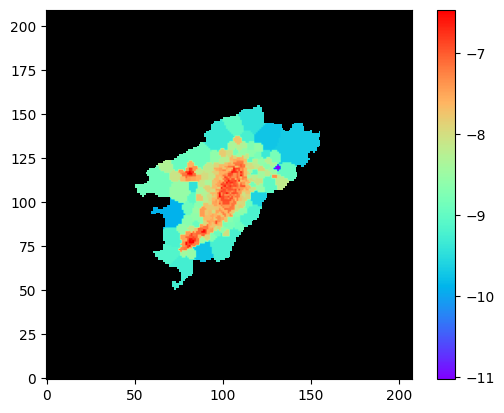

In [9]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from astropy.io import fits
fig, axs = plt.subplots(1, 1)

seg_map = fits.getdata(binned_data_path, hdu="SEG_MAP")

plot_map = np.full_like(seg_map, np.nan, dtype=float)
for row in fit.cat:
    plot_map[seg_map == int(row["#ID"])] = (
        row[
            # "continuity:massformed_50"
            # "stellar_mass_50"
            "ssfr_50"
            # "sfr_50"
            # "continuity:metallicity_50"
            # "mass_weighted_age_50"
            # "dust:Av_50"
            # "dust:eta"
            # "nebular:logU_50"
            # "redshift_50"
        ]
        # *row[
        #     "dust:eta_50"
        # ]
        # /
        -
        np.log10(
        (len((seg_map == int(row["#ID"])).nonzero()[0])
        * ((0.04 * 4.63) ** 2))
        )
    )
plot_map[seg_map==0] = np.nan
im = axs.imshow(
    plot_map,
    # np.log10(plot_map),
    origin="lower",
    # vmin=3,
    # vmax=9,
    # vmin=-4,
    # vmax=1,
    # vmin=-12,
    # vmax=-8,
    # vmin=-8,
    # vmax=-3,
    # cmap="plasma",
    # vmin=0,
    cmap="rainbow"
    # cmap = cmc.lajolla
)
axs.set_facecolor("k")
plt.colorbar(im)

plt.show()

In [10]:
grizli_extraction_dir = root_dir / "2024_08_16_A2744_v4" / "grizli_home" / "Extractions"
grizli_extraction_dir.mkdir(exist_ok=True)
beams_path = [*grizli_extraction_dir.glob(f"**/*{obj_id}.beams.fits")]

from grizli import jwst_utils
import logging
jwst_utils.QUIET_LEVEL = logging.WARNING
jwst_utils.set_quiet_logging(jwst_utils.QUIET_LEVEL)


if len(beams_path)==0:
    from grizli import multifit, fitting
    from grizli.pipeline import auto_script

    os.chdir(grizli_extraction_dir)

    flt_files = [str(s) for s in Path.cwd().glob("*GrismFLT.fits")][:]

    grp = multifit.GroupFLT(
        grism_files=flt_files,
        catalog=f"{root_name}-ir.cat.fits",
        cpu_count=-1,
        sci_extn=1,
        pad=800,
    )

    print("5. Extracting spectra...")
    pline = {
        "kernel": "gaussian",
        "pixfrac": 0.8,
        "pixscale": 0.03,
        "size": 3,
        "wcs": None,
    }
    args = auto_script.generate_fit_params(
        pline=pline,
        field_root=root_name,
        min_sens=0.0,
        min_mask=0.0,
        include_photometry=False,  # set both of these to True to include photometry in fitting
        use_phot_obj=False,
    )

    # for id in obj["id"]):
    # print(id)
    # obj_id = 1597
    # obj_z = 2.6724
    # obj_id = 3311
    # obj_z = 1.3397
    # obj_id = 1761
    # obj_z = 3.06
    # obj_id = 886
    # obj_z = 0.3033
    # obj_id = 2308
    # obj_z = 0.3033
    beams = grp.get_beams(
        obj_id,
        # center_rd = (3.60940, -30.39839),
        size=25,  # Make sure the size here is large enough to avoid the beam being cut off
        min_mask=0,
        min_sens=0,
        show_exception=True,
        beam_id="A",
    )
    # print (beams)
    mb = multifit.MultiBeam(
        beams, fcontam=0.2, min_sens=0.0, min_mask=0, group_name=root_name
    )
    mb.fit_trace_shift()
    # _ = mb.oned_figure()
    #     _ = mb.drizzle_grisms_and_PAs(size=32, scale=0.5, diff=False)
    mb.write_master_fits()
    from grizli import fitting

    _ = fitting.run_all_parallel(
        obj_id,
        zr=[obj_z-0.02, obj_z + 0.02],
        # zr = [2.5,3.5],
        dz=[0.0005,0.00001],
        verbose=True,
        get_output_data=True,
        skip_complete=False,
        save_figures=True,
    )
    print("5. Extracting spectra...[COMPLETE]")

1.15.0.dev0+git20241115.1c9b1aa


 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
[0.61750662 0.58687055 0.55012715 ... 0.36642689 0.38380045 0.38139689]
iteration chi2 base_coeffs_0 base_coeffs_1 ... 571_1 571_2 571_3 571_4
--------- ---- ------------- ------------- ... ----- ----- ----- -----
2864
/media/shar

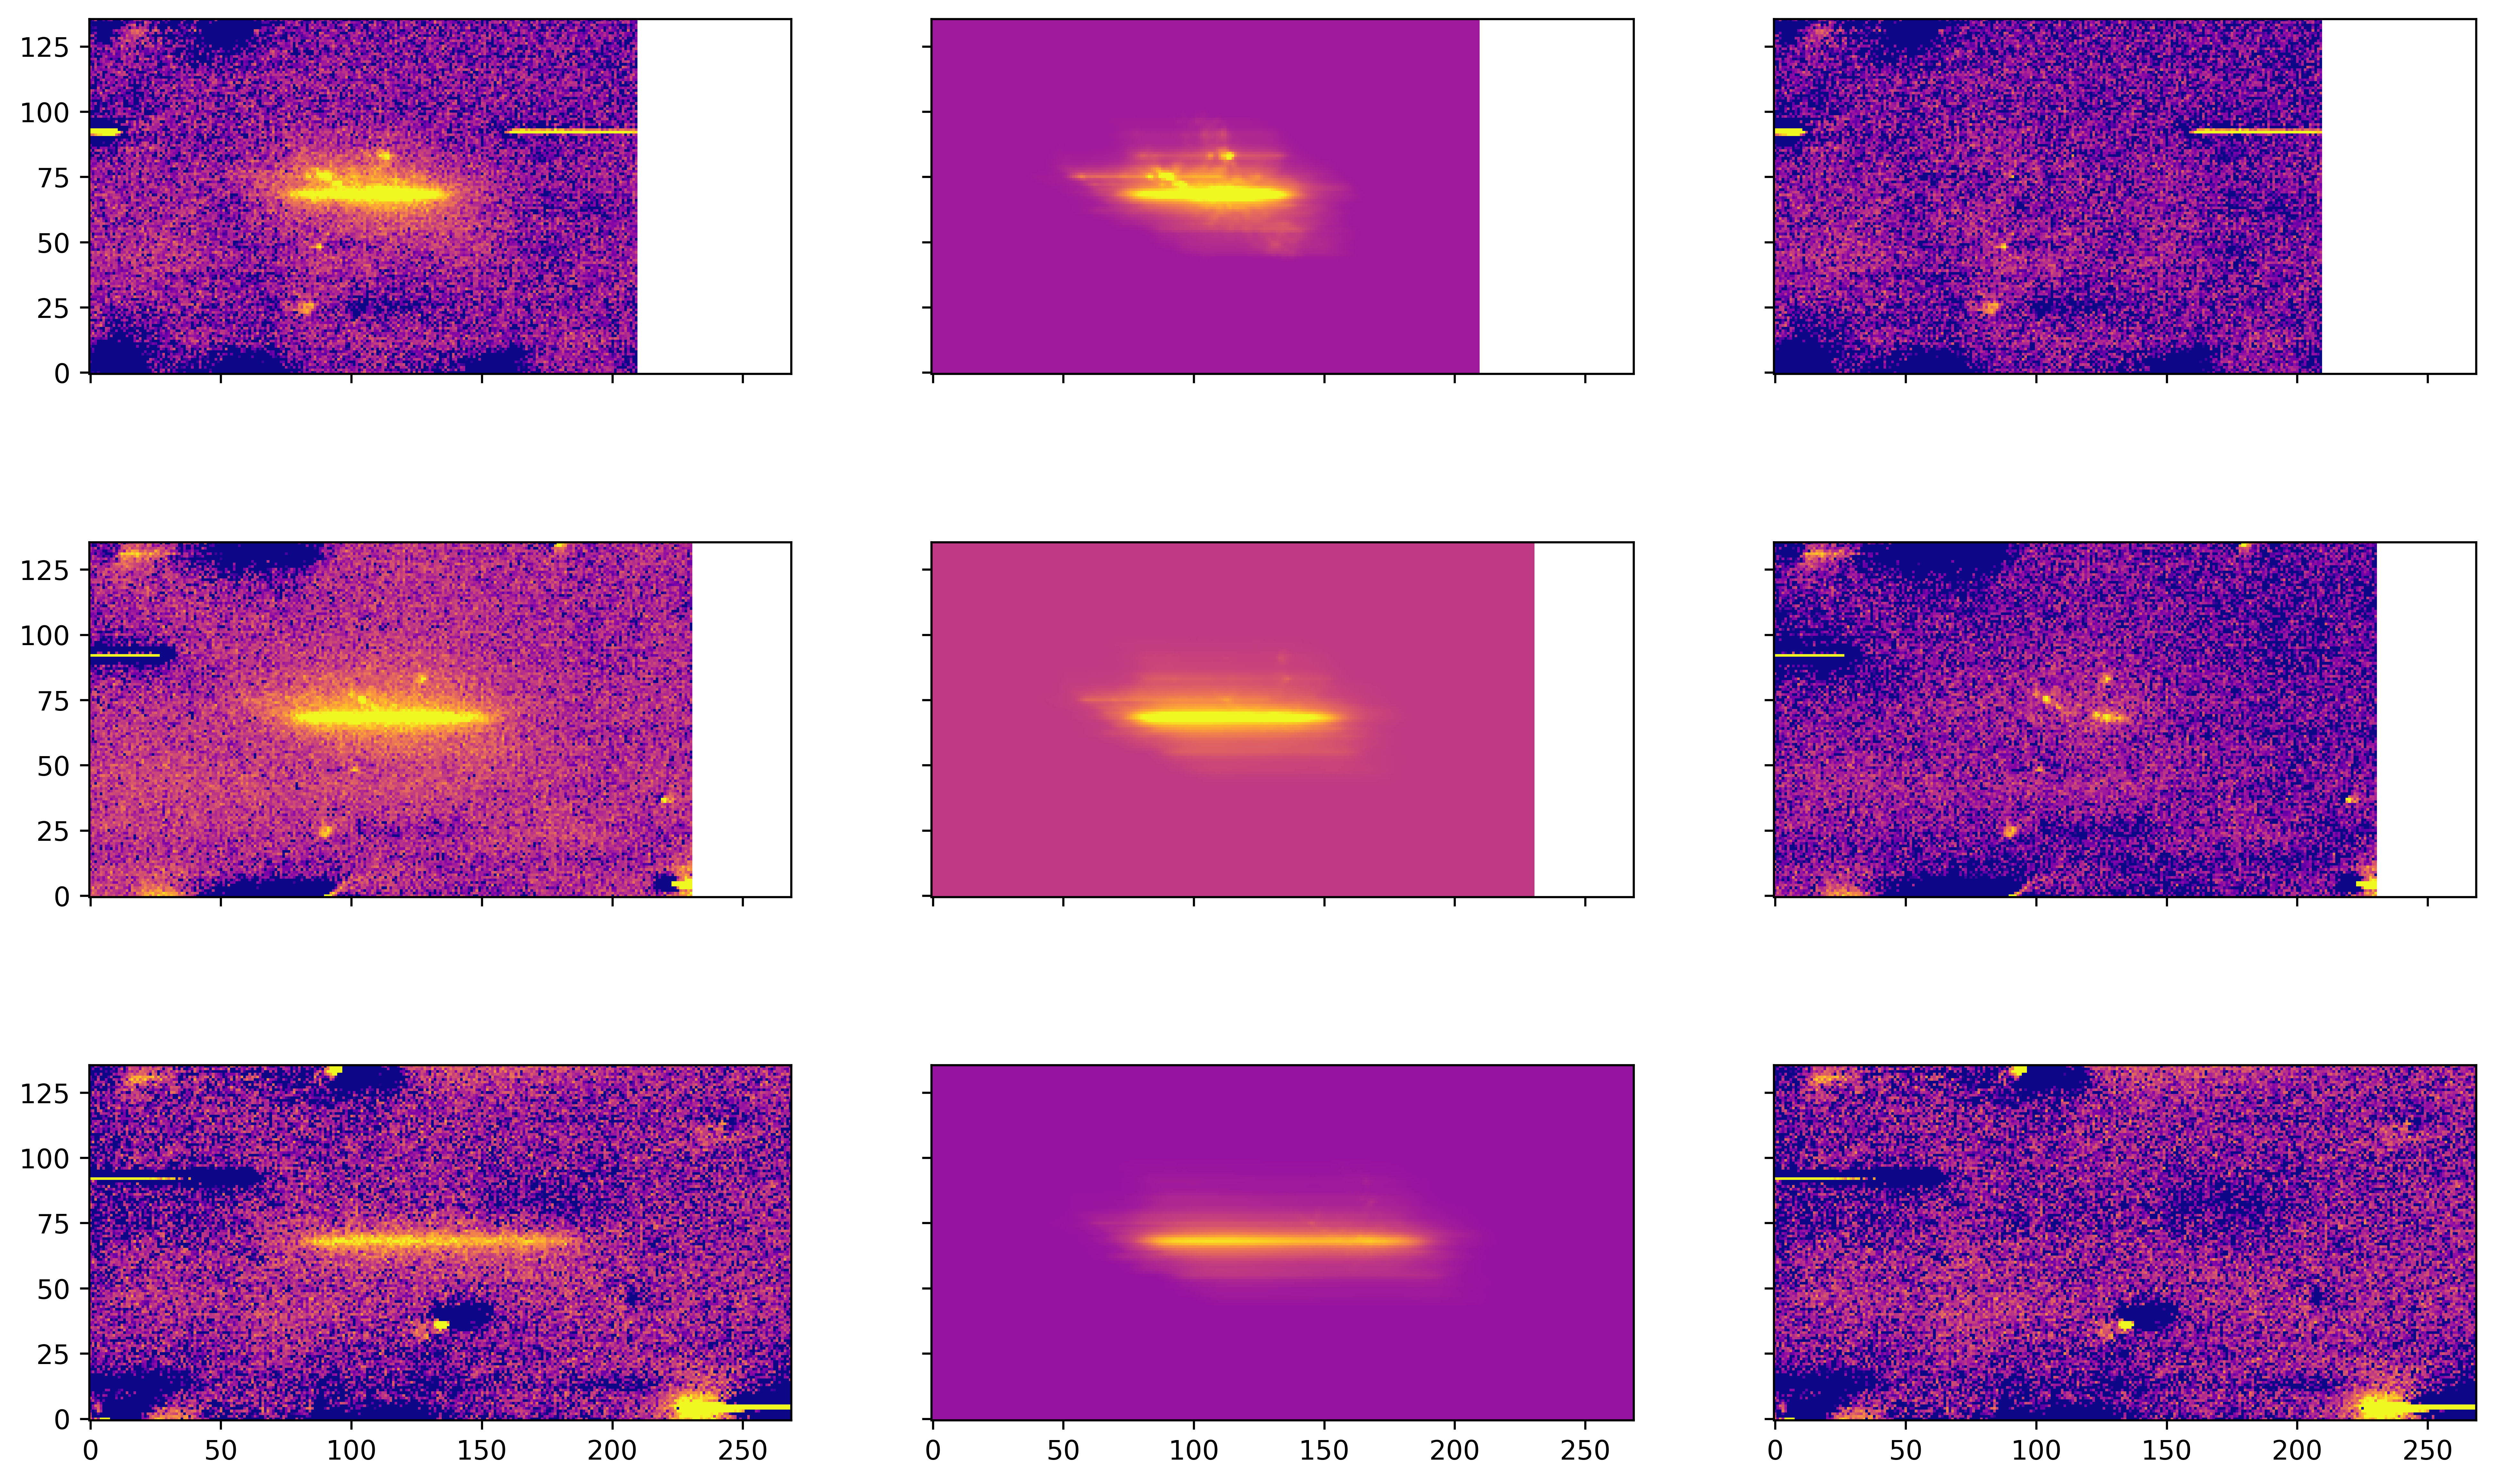

rms 0.020979305705123363
0.9002262387390199
0.810407280921936
2272.0494384765625
0.0004401312678925085
rms 0.020255621706265006
0.8715987344877063
0.7596843540668488
2437.2991943359375
0.0004102902107083708
rms 0.018151950504202364
0.8195797144847063
0.6717109084129333
3034.9630126953125
0.00032949330710744785


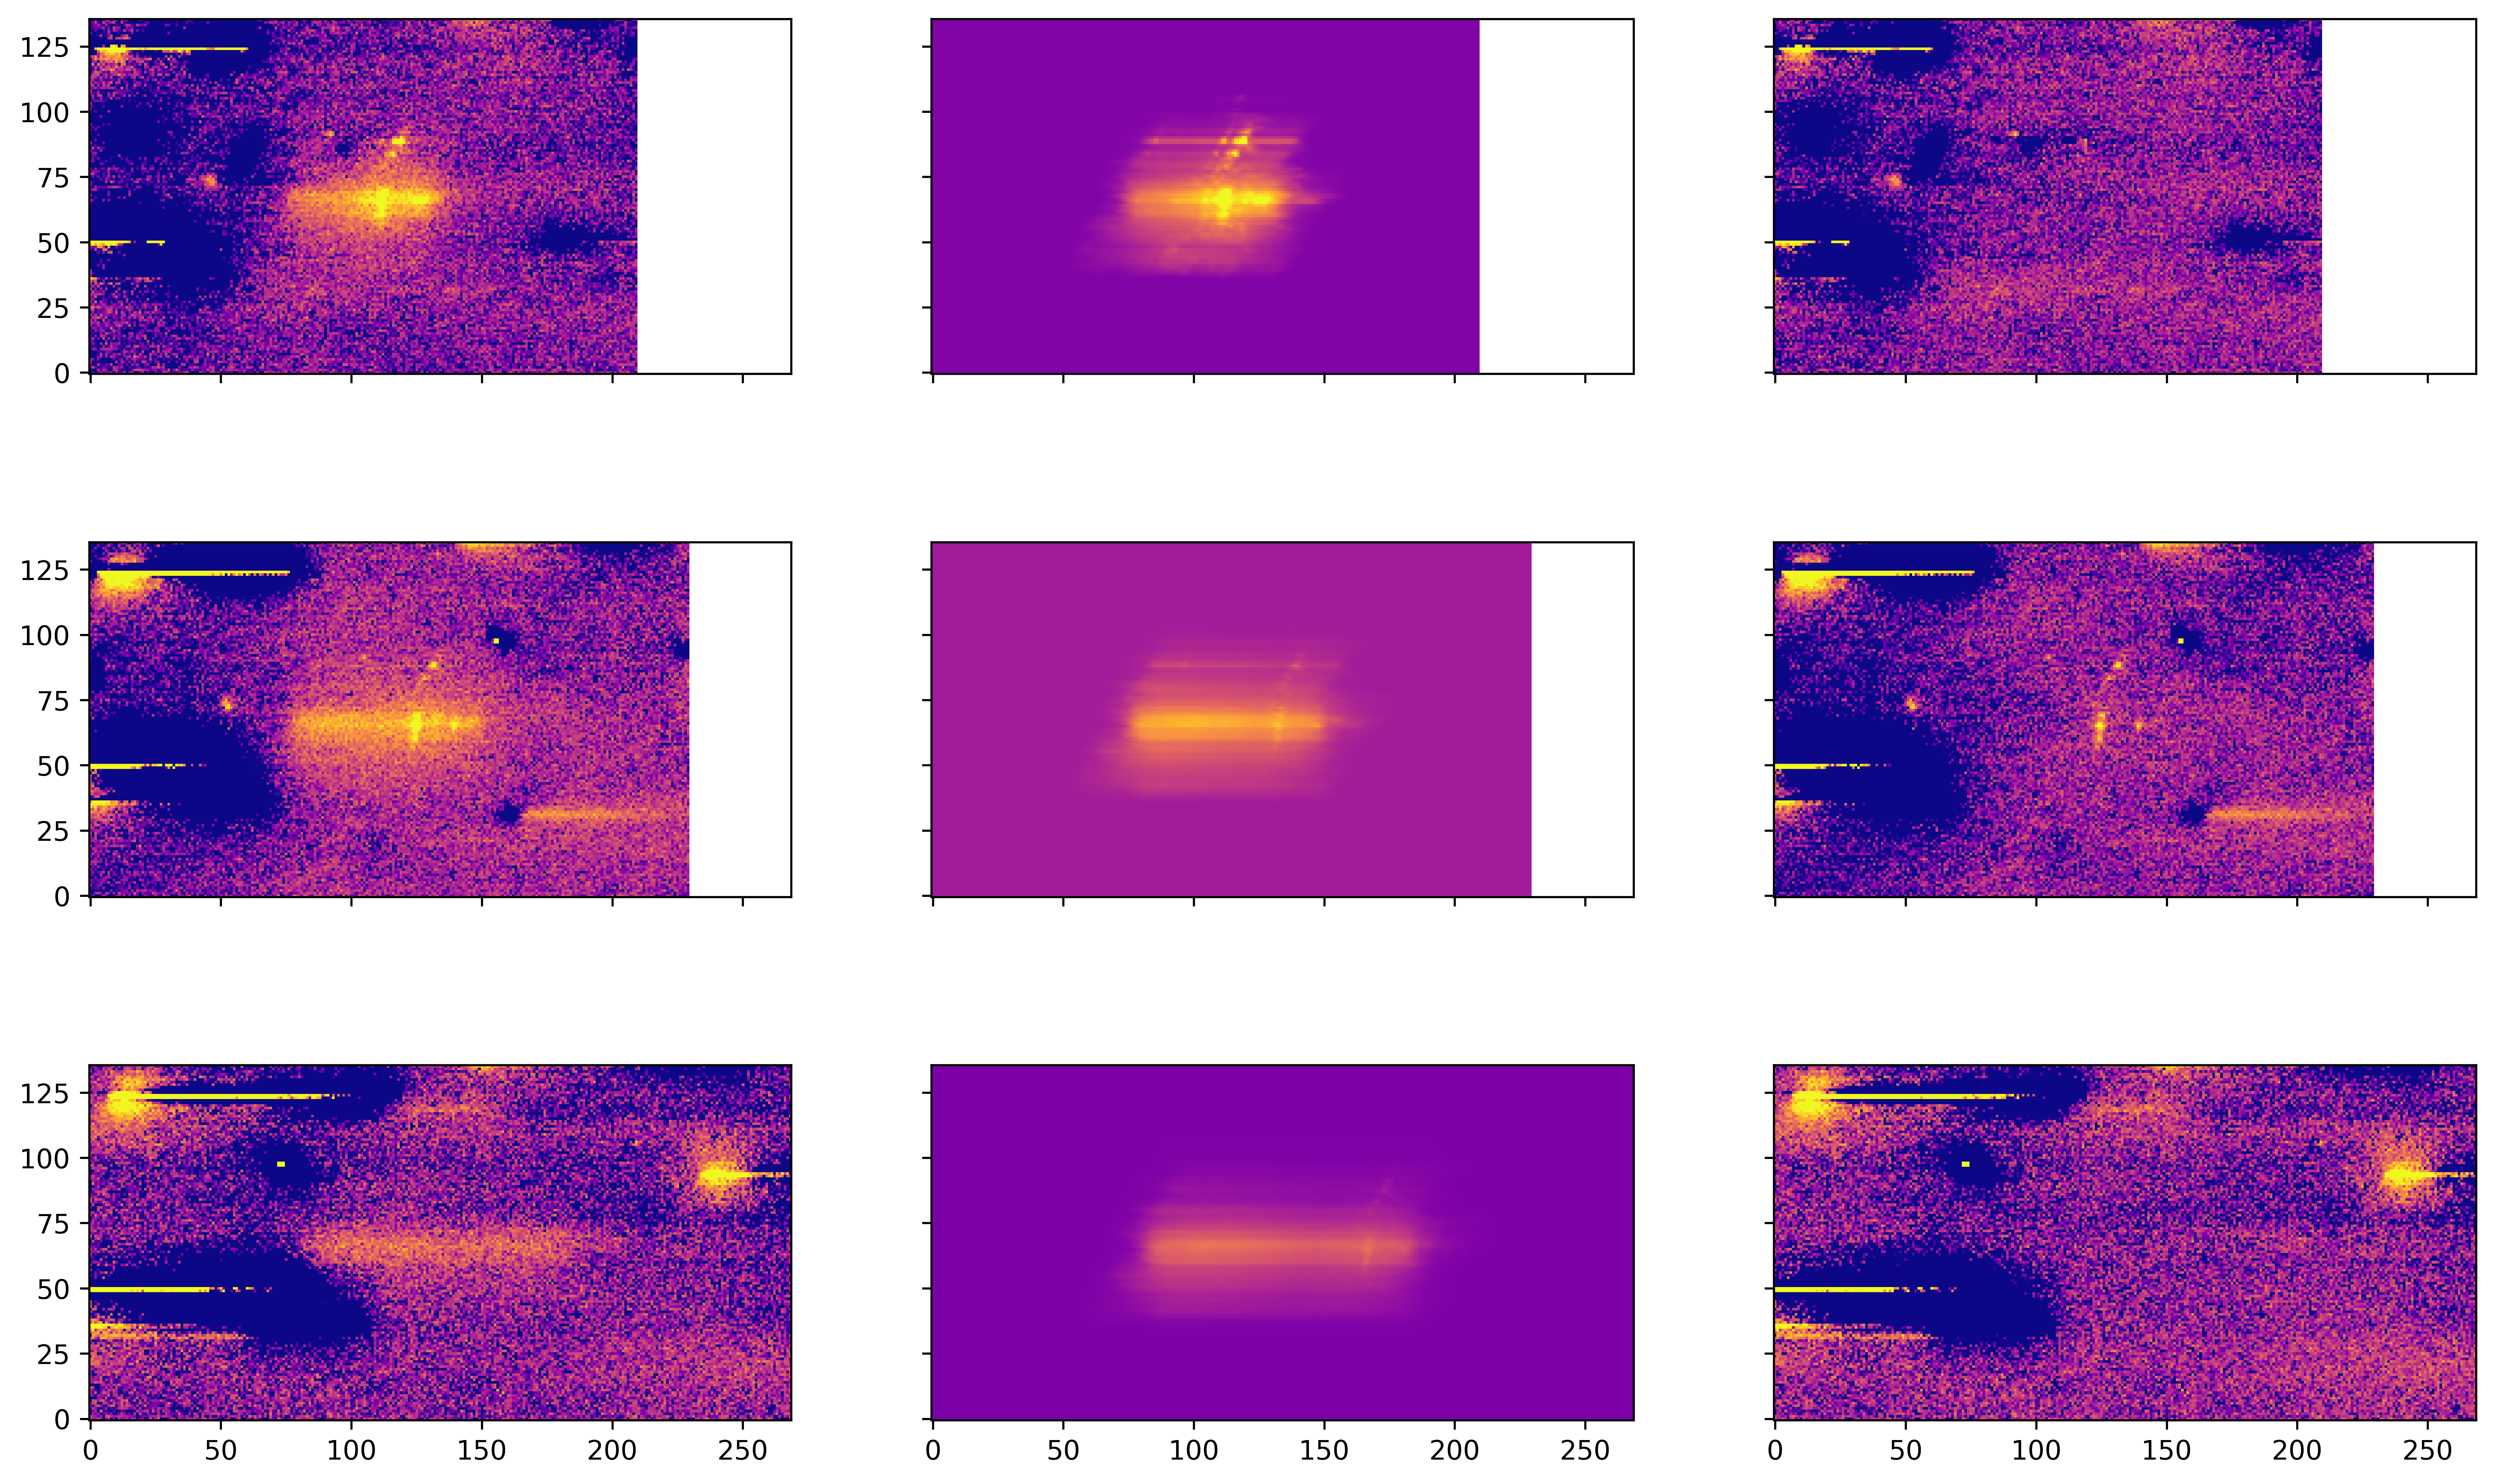

1 40
6
out_coeffs=array([3.23799066e-03, 3.78531288e-03, 1.24072164e-02, ...,
       1.21233279e+01, 0.00000000e+00, 0.00000000e+00])
[0.] [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


(array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([3.23799066e-03, 3.78531288e-03, 1.24072164e-02, ...,
        1.21233279e+01, 0.00000000e+00, 0.00000000e+00]),
 np.float64(19308.02036291459),
 array([ 0.00323799,  0.00323799,  0.00323799, ..., -0.00273176,
        -0.00273176, -0.00273176]))

In [11]:
from glass_niriss.grism import RegionsMultiBeam
import scipy
print (scipy.__version__)


grizli_extraction_dir = (
    root_dir / "2024_08_16_A2744_v4" / "grizli_home" / "Extractions"
)

beams_path = [*grizli_extraction_dir.glob(f"**/*{obj_id}.beams.fits")]
if len(beams_path) >= 1:
    beams_path = beams_path[0]
else:
    raise IOError("Beams file does not exist.")

multib = RegionsMultiBeam(
    binned_data=binned_data_path,
    pipes_dir=pipes_dir,
    # f"bcg_{obj_id}_{bin_mode}_{bin_size}_{sn_target}_z_{obj_z}_{obj_z}_{atlas_size:.2E}",
    run_name=f"{binned_name}_{run_name}",
    beams=str(beams_path),
    min_mask=0.0,
    min_sens=0.0,
    mask_resid=False,
    verbose=False,
    fcontam=0.2,
)

multib.fit_at_z(
    z=obj_z,
    n_samples=5,
    veldisp=250,
    oversamp_factor=3,
    fit_stacks=True,
    temp_dir=Path("/media/sharedData/data/2024_08_16_A2744_v4/tests"),
    # direct_images=direct_images, poly_order=3
    num_iters=1,
    # force_iter=6,
    cpu_count=16,
)
#  5951.500383762376
# 3m29.1s 18304.046020146823
# 112m49.4s 176196.87852259478
# 6m03.5s 18303.616206350922
# 3m18.2s 18304.046020146823
# 2m20.2s 18304.046020146823
# 6m25.6s 18300.510210524993 num_iters=10, n_samp=5, max_iter=100
# 5m33.5s 18300.510210524993 num_iters=10, n_samp=5, max_iter=100
# 14m13.1s 18278.61965261226 num_iters=30, n_samp=5, max_iter=100
# 4m23.2s 18300.510210524993 num_iters=10, n_samp=5, max_iter=100
# 4m00.8s 18093.1961886456 num_iters=10, n_samp=5, max_iter=100, z=1.364, z_range=0.005
# 3m55.0s 18275.08501636544 num_iters=10, n_samp=5, max_iter=100, z=1.369, z_range=0.005
# 7m27.7s 18173.297117782884 num_iters=30, n_samp=5, max_iter=100, z=1.364, z_range=0.005, bin_diameter=4 [iter=16]
# 7m27.7s 18173.297117782884 num_iters=50, n_samp=5, max_iter=100, z=1.364, z_range=0.005, bin_diameter=4, veldisp=250 [iter=34]
# 4m22.3s 18090.156777429238 num_iters=10, n_samp=5, max_iter=100, z=1.364, z_range=0.005, bin_diameter=3, veldisp=250 [iter=02]
# 1m23.2s 17847.09863881481 num_iters=1, n_samp=5, max_iter=100, z=1.364, z_range=0.005, bin_diameter=-1, veldisp=250 [iter=00]
# 6m52.8s 17845.588886482128 num_iters=10, n_samp=5, max_iter=100, z=1.364, z_range=0.005, bin_diameter=-1, veldisp=250 [iter=06]



In [12]:
5336.264587846525

def _check_errs_dict(params, min_uncertainties: dict | None = None):
    
    if min_uncertainties is None:
        add_errs = None
    else:
        add_errs = np.zeros((500, len(params)))
        # for n in self.params:
        for k, v in min_uncertainties.items():
            print (k)
            for i in [j for j,n in enumerate(params) if k in n]:
                print (i)
                add_errs[:,i] = rng.normal(loc=0.0,scale=v,size=500)

params = ["continuity:massformed", "continuity:dsfr1", "continuity:dsfr2", "continuity:dustAvtest"]

default_min_errs = {
    "continuity:massformed" : 0.01,
    "continuity:metallicity" : 0.01,
    "continuity:dsfr" : 0.01
}
rng = np.random.default_rng(seed=2744)
_check_errs_dict(params, default_min_errs)

continuity:massformed
0
continuity:metallicity
continuity:dsfr
1
2
